## Using Convolutional Neural Network to Classify Music Genre

In [1]:
# feature extraction
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display
import random
import warnings
import os
from PIL import Image
import pathlib
import csv
# preprocessing
from sklearn.model_selection import train_test_split
# deep learning modeling
import keras
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
import split_folders
split_folders.ratio('./img_data/', output="./data", seed=1337, ratio=(.8, .2)) # default values

Copying files: 1000 files [00:10, 100.00 files/s]


In [2]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale all pixel values from 0-255 to 0-1
        shear_range=0.2, 
        zoom_range=0.2, #apply zoom
        horizontal_flip=True) 
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
training_set = train_datagen.flow_from_directory(
        './data/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)
test_set = test_datagen.flow_from_directory(
        './data/val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False )

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [4]:
model = Sequential()
input_shape=(64, 64, 3)
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 31, 32)        896       
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)         

In [9]:
epochs = 200
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, 
          momentum=momentum, 
          decay=decay_rate, 
          nesterov=False)

model.compile(optimizer="sgd", 
              loss="categorical_crossentropy", 
              metrics=['accuracy'])

In [11]:
history = model.fit_generator(
        training_set,
        steps_per_epoch=100,
        epochs=50,
        validation_data=test_set,
        validation_steps=200)

#model Evaluation
results=model.evaluate_generator(generator=test_set, steps=50)
print('test loss, test acc:', results)


Epoch 1/50
100/100 [==============================] - 99s 993ms/step - loss: 2.3075 - accuracy: 0.0794 - val_loss: 2.2771 - val_accuracy: 0.1337
Epoch 2/50
100/100 [==============================] - 102s 1s/step - loss: 2.3018 - accuracy: 0.1047 - val_loss: 2.3017 - val_accuracy: 0.1701
Epoch 3/50
100/100 [==============================] - 97s 968ms/step - loss: 2.2953 - accuracy: 0.1194 - val_loss: 2.2134 - val_accuracy: 0.1561
Epoch 4/50
100/100 [==============================] - 91s 914ms/step - loss: 2.2871 - accuracy: 0.1316 - val_loss: 2.2963 - val_accuracy: 0.1436
Epoch 5/50
100/100 [==============================] - 95s 951ms/step - loss: 2.2766 - accuracy: 0.1341 - val_loss: 2.3966 - val_accuracy: 0.1840
Epoch 6/50
100/100 [==============================] - 92s 924ms/step - loss: 2.2623 - accuracy: 0.1494 - val_loss: 2.2952 - val_accuracy: 0.1841
Epoch 7/50
100/100 [==============================] - 98s 981ms/step - loss: 2.2445 - accuracy: 0.1641 - val_loss: 2.0087 - val_accu

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


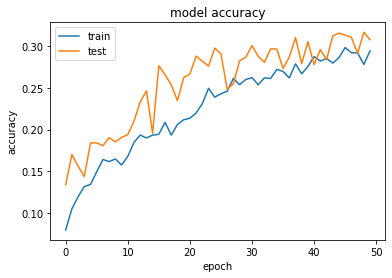

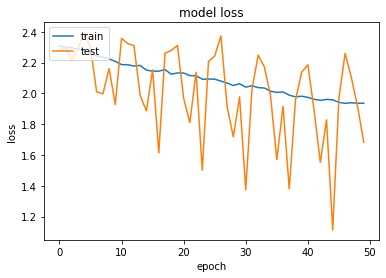

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_accuracy')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_loss')
plt.show()

In [14]:
# make predictions
test_set.reset()
pred = model.predict_generator(test_set, steps=50, verbose=1)

50/50 [==============================] - 15s 300ms/step


In [15]:
# compare predictions with test data to evaluate the what the model got wrong
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

In [18]:
print(len(filenames), len(predictions))

200 200


In [22]:
# make a dictionary of evaluations and save as CSV
dict_ = {"Filename":filenames,
        "Predictions":predictions}
prepared_dict = {i: x for i, x in enumerate(dict_.items())}
results=pd.DataFrame.from_dict(prepared_dict, 
                      orient='index',
                      columns=['Filename', 'Prediction'])
results.to_csv("prediction_results.csv",index=False)

In [23]:
from keras.models import load_model
model.save('CCN_genre_clf_1.sav')
print('model saved')

model saved


The model's accuracy is not nearly as good as the ANN we built earlier - lets see if we can change some parameters about the training to see if we can acheive more accurate classification

In [24]:
# first lets change the number of epochs and see if our original settings just need more time to train
epochs = 200
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, 
          momentum=momentum, 
          decay=decay_rate, 
          nesterov=False)

model.compile(optimizer="sgd", 
              loss="categorical_crossentropy", 
              metrics=['accuracy'])


history = model.fit_generator(
        training_set,
        steps_per_epoch=100,
        epochs=150,
        validation_data=test_set,
        validation_steps=200)

#model Evaluation
results=model.evaluate_generator(generator=test_set, steps=50)
print('test loss, test acc:', results)


/step - loss: 1.8858 - accuracy: 0.3078 - val_loss: 1.7153 - val_accuracy: 0.3132
Epoch 16/150
100/100 [==============================] - 99s 995ms/step - loss: 1.8870 - accuracy: 0.3066 - val_loss: 1.9006 - val_accuracy: 0.3224
Epoch 17/150
100/100 [==============================] - 95s 949ms/step - loss: 1.8837 - accuracy: 0.3200 - val_loss: 1.1743 - val_accuracy: 0.3205
Epoch 18/150
100/100 [==============================] - 92s 922ms/step - loss: 1.8737 - accuracy: 0.3122 - val_loss: 2.0071 - val_accuracy: 0.3131
Epoch 19/150
100/100 [==============================] - 102s 1s/step - loss: 1.8800 - accuracy: 0.3081 - val_loss: 2.1825 - val_accuracy: 0.3209
Epoch 20/150
100/100 [==============================] - 115s 1s/step - loss: 1.8721 - accuracy: 0.3106 - val_loss: 2.2608 - val_accuracy: 0.3326
Epoch 21/150
100/100 [==============================] - 97s 974ms/step - loss: 1.8754 - accuracy: 0.3091 - val_loss: 1.7464 - val_accuracy: 0.3170
Epoch 22/150
100/100 [==================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


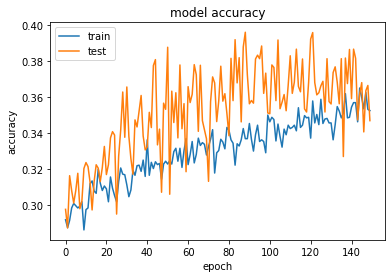

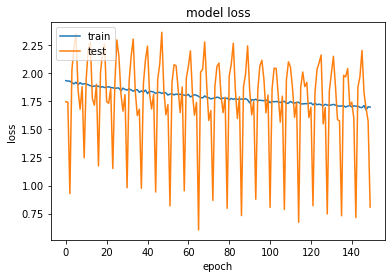

In [25]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_accuracy_1')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_loss_1')
plt.show()

In [27]:
# make predictions
test_set.reset()
pred = model.predict_generator(test_set, steps=150, verbose=1)

150/150 [==============================] - 47s 315ms/step


In [28]:
# compare predictions with test data to evaluate the what the model got wrong
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

In [30]:
print(len(filenames), len(predictions))

200 200


In [31]:
# make a dictionary of evaluations and save as CSV
dict_ = {"Filename":filenames,
        "Predictions":predictions}
prepared_dict = {i: x for i, x in enumerate(dict_.items())}
results=pd.DataFrame.from_dict(prepared_dict, 
                      orient='index',
                      columns=['Filename', 'Prediction'])
results.to_csv("prediction_results_2.csv",index=False)

In [32]:
from keras.models import load_model
model.save('CCN_genre_clf_2.sav')
print('model saved')

model saved


The CNN is still under performing in comparison to our intial neural network. Rather than give our parameters more time to train, lets adjust the parameters

In [34]:
# here we changed the batch size, learning rate, and momentum as well as increase the training time
epochs = 200
batch_size = 20
learning_rate = 0.02
decay_rate = learning_rate / epochs
momentum = 0.95
sgd = SGD(lr=learning_rate, 
          momentum=momentum, 
          decay=decay_rate, 
          nesterov=False)

model.compile(optimizer="sgd", 
              loss="categorical_crossentropy", 
              metrics=['accuracy'])


history = model.fit_generator(
        training_set,
        steps_per_epoch=200,
        epochs=250,
        validation_data=test_set,
        validation_steps=400)

#model Evaluation
results=model.evaluate_generator(generator=test_set, steps=50)
print('test loss, test acc:', results)

200 [==============================] - 203s 1s/step - loss: 1.5120 - accuracy: 0.4236 - val_loss: 1.5620 - val_accuracy: 0.3600
Epoch 117/250
200/200 [==============================] - 201s 1s/step - loss: 1.5113 - accuracy: 0.4244 - val_loss: 0.9086 - val_accuracy: 0.3612
Epoch 118/250
200/200 [==============================] - 197s 987ms/step - loss: 1.5170 - accuracy: 0.4175 - val_loss: 2.0800 - val_accuracy: 0.3844
Epoch 119/250
200/200 [==============================] - 203s 1s/step - loss: 1.5141 - accuracy: 0.4206 - val_loss: 1.8200 - val_accuracy: 0.3747
Epoch 120/250
200/200 [==============================] - 199s 995ms/step - loss: 1.5280 - accuracy: 0.4181 - val_loss: 1.7288 - val_accuracy: 0.3601
Epoch 121/250
200/200 [==============================] - 197s 985ms/step - loss: 1.5136 - accuracy: 0.4172 - val_loss: 1.9322 - val_accuracy: 0.3796
Epoch 122/250
200/200 [==============================] - 205s 1s/step - loss: 1.5089 - accuracy: 0.4328 - val_loss: 2.1473 - val_accu

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


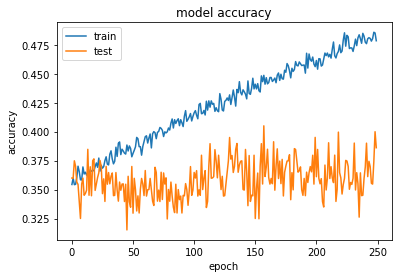

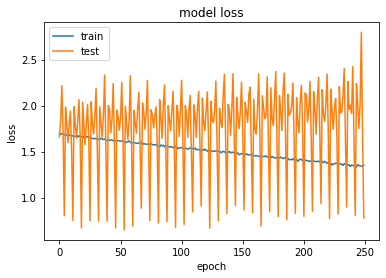

In [37]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_accuracy_2')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_loss_2')
plt.show()

In [38]:
# make predictions
test_set.reset()
pred = model.predict_generator(test_set, steps=250, verbose=1)

250/250 [==============================] - 75s 300ms/step


In [39]:
# compare predictions with test data to evaluate the what the model got wrong
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

In [40]:
print(len(filenames), len(predictions))

200 200


In [41]:
# make a dictionary of evaluations and save as CSV
dict_ = {"Filename":filenames,
        "Predictions":predictions}
prepared_dict = {i: x for i, x in enumerate(dict_.items())}
results=pd.DataFrame.from_dict(prepared_dict, 
                      orient='index',
                      columns=['Filename', 'Prediction'])
results.to_csv("prediction_results_3.csv",index=False)

In [42]:
from keras.models import load_model
model.save('CCN_genre_clf_3.sav')
print('model saved')

model saved


Here, there seems to be more accuracy but the training is overfitting. Lets try one more attempt and lower the training time but keep the new parameters

In [5]:
epochs = 200
batch_size = 20
learning_rate = 0.02
decay_rate = learning_rate / epochs
momentum = 0.95
sgd = SGD(lr=learning_rate, 
          momentum=momentum, 
          decay=decay_rate, 
          nesterov=False)

model.compile(optimizer="sgd", 
              loss="categorical_crossentropy", 
              metrics=['accuracy'])


history = model.fit_generator(
        training_set,
        steps_per_epoch=200,
        epochs=50,
        validation_data=test_set,
        validation_steps=400)

#Model Evaluation
results=model.evaluate_generator(generator=test_set, steps=200)
print('test loss, test acc:', results)

Epoch 1/50
200/200 [==============================] - 226s 1s/step - loss: 2.3127 - accuracy: 0.0697 - val_loss: 2.3027 - val_accuracy: 0.1645
Epoch 2/50
200/200 [==============================] - 198s 991ms/step - loss: 2.3058 - accuracy: 0.0708 - val_loss: 2.2994 - val_accuracy: 0.1648
Epoch 3/50
200/200 [==============================] - 202s 1s/step - loss: 2.2978 - accuracy: 0.0958 - val_loss: 2.2912 - val_accuracy: 0.1646
Epoch 4/50
200/200 [==============================] - 199s 996ms/step - loss: 2.2834 - accuracy: 0.1152 - val_loss: 2.2182 - val_accuracy: 0.1802
Epoch 5/50
200/200 [==============================] - 200s 1s/step - loss: 2.2622 - accuracy: 0.1420 - val_loss: 2.0520 - val_accuracy: 0.1959
Epoch 6/50
200/200 [==============================] - 201s 1s/step - loss: 2.2384 - accuracy: 0.1683 - val_loss: 2.2898 - val_accuracy: 0.2194
Epoch 7/50
200/200 [==============================] - 184s 921ms/step - loss: 2.2090 - accuracy: 0.1711 - val_loss: 2.1147 - val_accurac

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


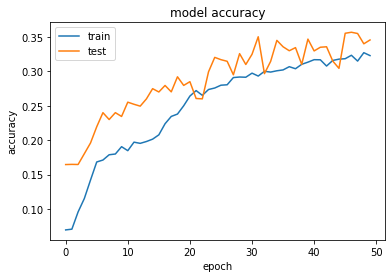

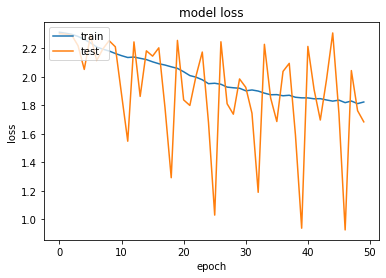

In [6]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_accuracy_3')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('CNN_training_loss_3')
plt.show()

In [7]:
test_set.reset()
pred = model.predict_generator(test_set, steps=50, verbose=1)

50/50 [==============================] - 25s 500ms/step


In [8]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

In [9]:
from keras.models import load_model
model.save('CCN_genre_clf_4.sav')
print('model saved')

model saved


After all that, we did increase the accuracy. However, we didn't even break 35% percent accuracy. 